Problem:

Let's suppose a school has 15 different classes with 3-10 students each. All the students study some number of hours, $H$, and then take a test, earning score $S$. We want to infer a relation between number of hours studied and test score. However, there is a complication: because some teachers are better than others, the mean score also varies from class to class. 

Let's assume the score of the ith student in the jth class is given by 

$$S_{ij}=mH_{ij}+b+{\rm offset}_{j} $$

To get a good constraint on $m$ (what we want), we'll also have to marginalize over the unknown ${\rm offset}_{j}$.

In [1]:
from __future__ import division # python2 compatibility
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# generate some data
import numpy as np
np.random.seed(1)
N_classes = 15
offsets = np.random.uniform(-5, 5, N_classes) # how much better or worse students in a given class will do. 

# true relation between scores and hours studied
m_true = 0.392
b_true = 15.12
f_true = 0.923

all_scores, all_hours = [], []
for i, offset in enumerate(offsets):
    N_students = np.random.randint(3, 10)
    H = np.sort(np.random.uniform(0, 10, N_students))
    S = m_true*H + b_true
    S += f_true * np.random.randn(N_students)
    S += offset
    all_hours.append(H)
    all_scores.append(S)
    


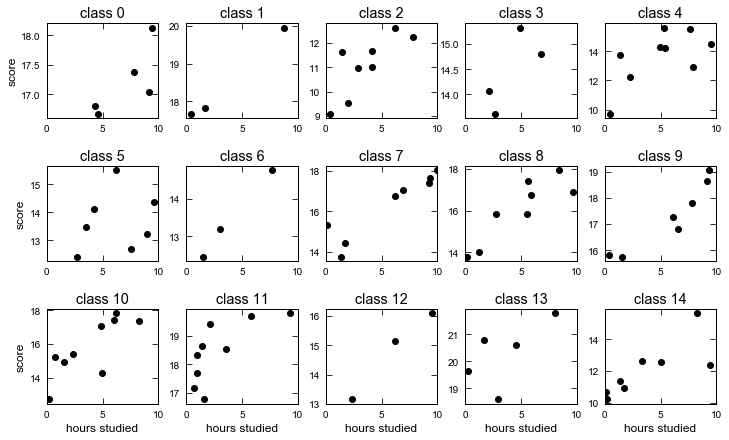

In [2]:
nrow, ncol = 3, 5
f, ax = plt.subplots(nrow, ncol, figsize = (12, 7))
plt.subplots_adjust(wspace = 0.25)
count = 0
for i in range(nrow):
    for j in range(ncol):
        ax[i, j].plot(all_hours[count], all_scores[count], 'ko', alpha = 1)
        ax[i, j].set_xlim(0, 10)
        ax[i, j].set_title('class %d' % count)
        if i == nrow - 1:
            ax[i, j].set_xlabel('hours studied')
        if j == 0:
            ax[i, j].set_ylabel('score')
        count += 1

In [3]:
# suppose we don't know how to build a hierarchical model. 
# In that case, we'd probably just try to fit the relation 
# for one of the classes. 

import pystan
stan_code = """
data {
    int n_students; // number int his class
    real scores[n_students]; // array of scores for this class
    real hours[n_students]; // array of hours for this class
}
parameters {
    real <lower=-1., upper=2.> m; // slope
    real <lower=5., upper=25> b; // intercept
    real <lower=-5.,upper=5> lnf; // intrinsic scatter
}
transformed parameters {
    real pred_score[n_students];
    real sigma[n_students];
    real f = exp(lnf);

    for (i in 1:n_students) {
        pred_score[i] =  b + m*hours[i]; // model 
        sigma[i] = f; // intrinsic scatter. If there were observation uncertainties, you'd add them in quadrature. 
    }
}
model {
    m ~ normal(0.5, 1);
    b ~ normal(15, 5);
    scores ~ normal(pred_score, sigma); // assume uncertainties are Gaussian. 
}
"""
stan_model= pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a8ac2061834913e9896c5117869cfebe NOW.


In [4]:
# fit class number 0
num = 0
fit= stan_model.sampling(data=dict(n_students=len(all_hours[num]),
        scores = all_scores[num], hours = all_hours[num]), iter=10000, chains=4)

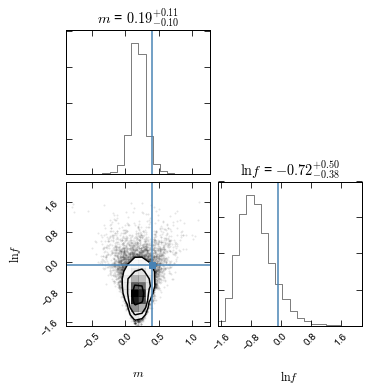

In [5]:
import corner
fig = corner.corner(np.array([fit['m'], fit['lnf']]).T,
                    labels=["$m$", "$\ln f$"],
                    show_titles=True, truths = [m_true, np.log(f_true)])

In [6]:
# OK, that's fine, we have a constraint on m. 

Text(0,0.5,'number of students')

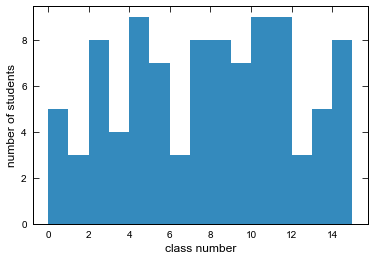

In [7]:
# get the data in order. 
nstud_class_i = [len(_) for _ in all_hours]
N_stud_tot = np.sum(nstud_class_i)

Scores_k, Hours_k, = np.array(N_stud_tot*[np.nan]), np.array(N_stud_tot*[np.nan])

count = 0
for i, class_hours in enumerate(all_hours):
    num = len(class_hours)
    Hours_k[count:count+num] = class_hours
    Scores_k[count:count+num] = all_scores[i]
    count += num
    
class_index_of_student_k = np.concatenate([n*[j] for j, n in enumerate(nstud_class_i)])

plt.hist(class_index_of_student_k, bins = np.arange(0, 16))
plt.xlabel('class number')
plt.ylabel('number of students')

In [8]:

import pystan
stan_code = """
data {
    int N_classes; // total number of classes
    int N_students; // Total number of students
    int class_index_of_student_k[N_students]; // which class index each student belongs to
    int zeropoint_index; // which class's offset we'll call zero

    real hours_k[N_students];
    real scores_k[N_students]; 
}

parameters {
    real<lower=-10,upper=10> offsets[N_classes-1]; // array of offsets relative to the zeropoint
    real <lower=-1., upper=2.> m; // slope
    real <lower=5., upper=25> b; // intercept
    real <lower=-5.,upper=5> lnf; // intrinsic scatter
}

transformed parameters {
    real pred_score[N_students];
    real sigma[N_students];
    real f= exp(lnf);
    real offset_k; // relative to the zeropoint class 
    for (k in 1:N_students) {
        int this_class_index = class_index_of_student_k[k]; 
        
        // find the appropriate offset index for this galaxy.
        if (this_class_index == zeropoint_index) {
            offset_k = 0.;
        } else if (this_class_index < zeropoint_index) {
            offset_k = offsets[this_class_index+1]; // Stan has 1-based indexing
        } else {
            offset_k = offsets[this_class_index];
        }
        
        pred_score[k] = offset_k + m*hours_k[k] + b ;
        sigma[k] = f; // add intrinsic scatter 
    }
}

model {
    m ~ normal(0.5, 1);
    b ~ normal(15, 5);
    scores_k ~ normal(pred_score, sigma);
}
"""
stan_model= pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3d51434b242aeb055b9b53023dec2bd5 NOW.


In [9]:
full_fit = stan_model.sampling(data=dict(N_classes=len(all_hours),
                                   N_students = N_stud_tot,
                                   class_index_of_student_k = class_index_of_student_k,
                                   zeropoint_index = 0,
                                   scores_k = Scores_k,
                                   hours_k = Hours_k),
                         iter=20000, chains=4)



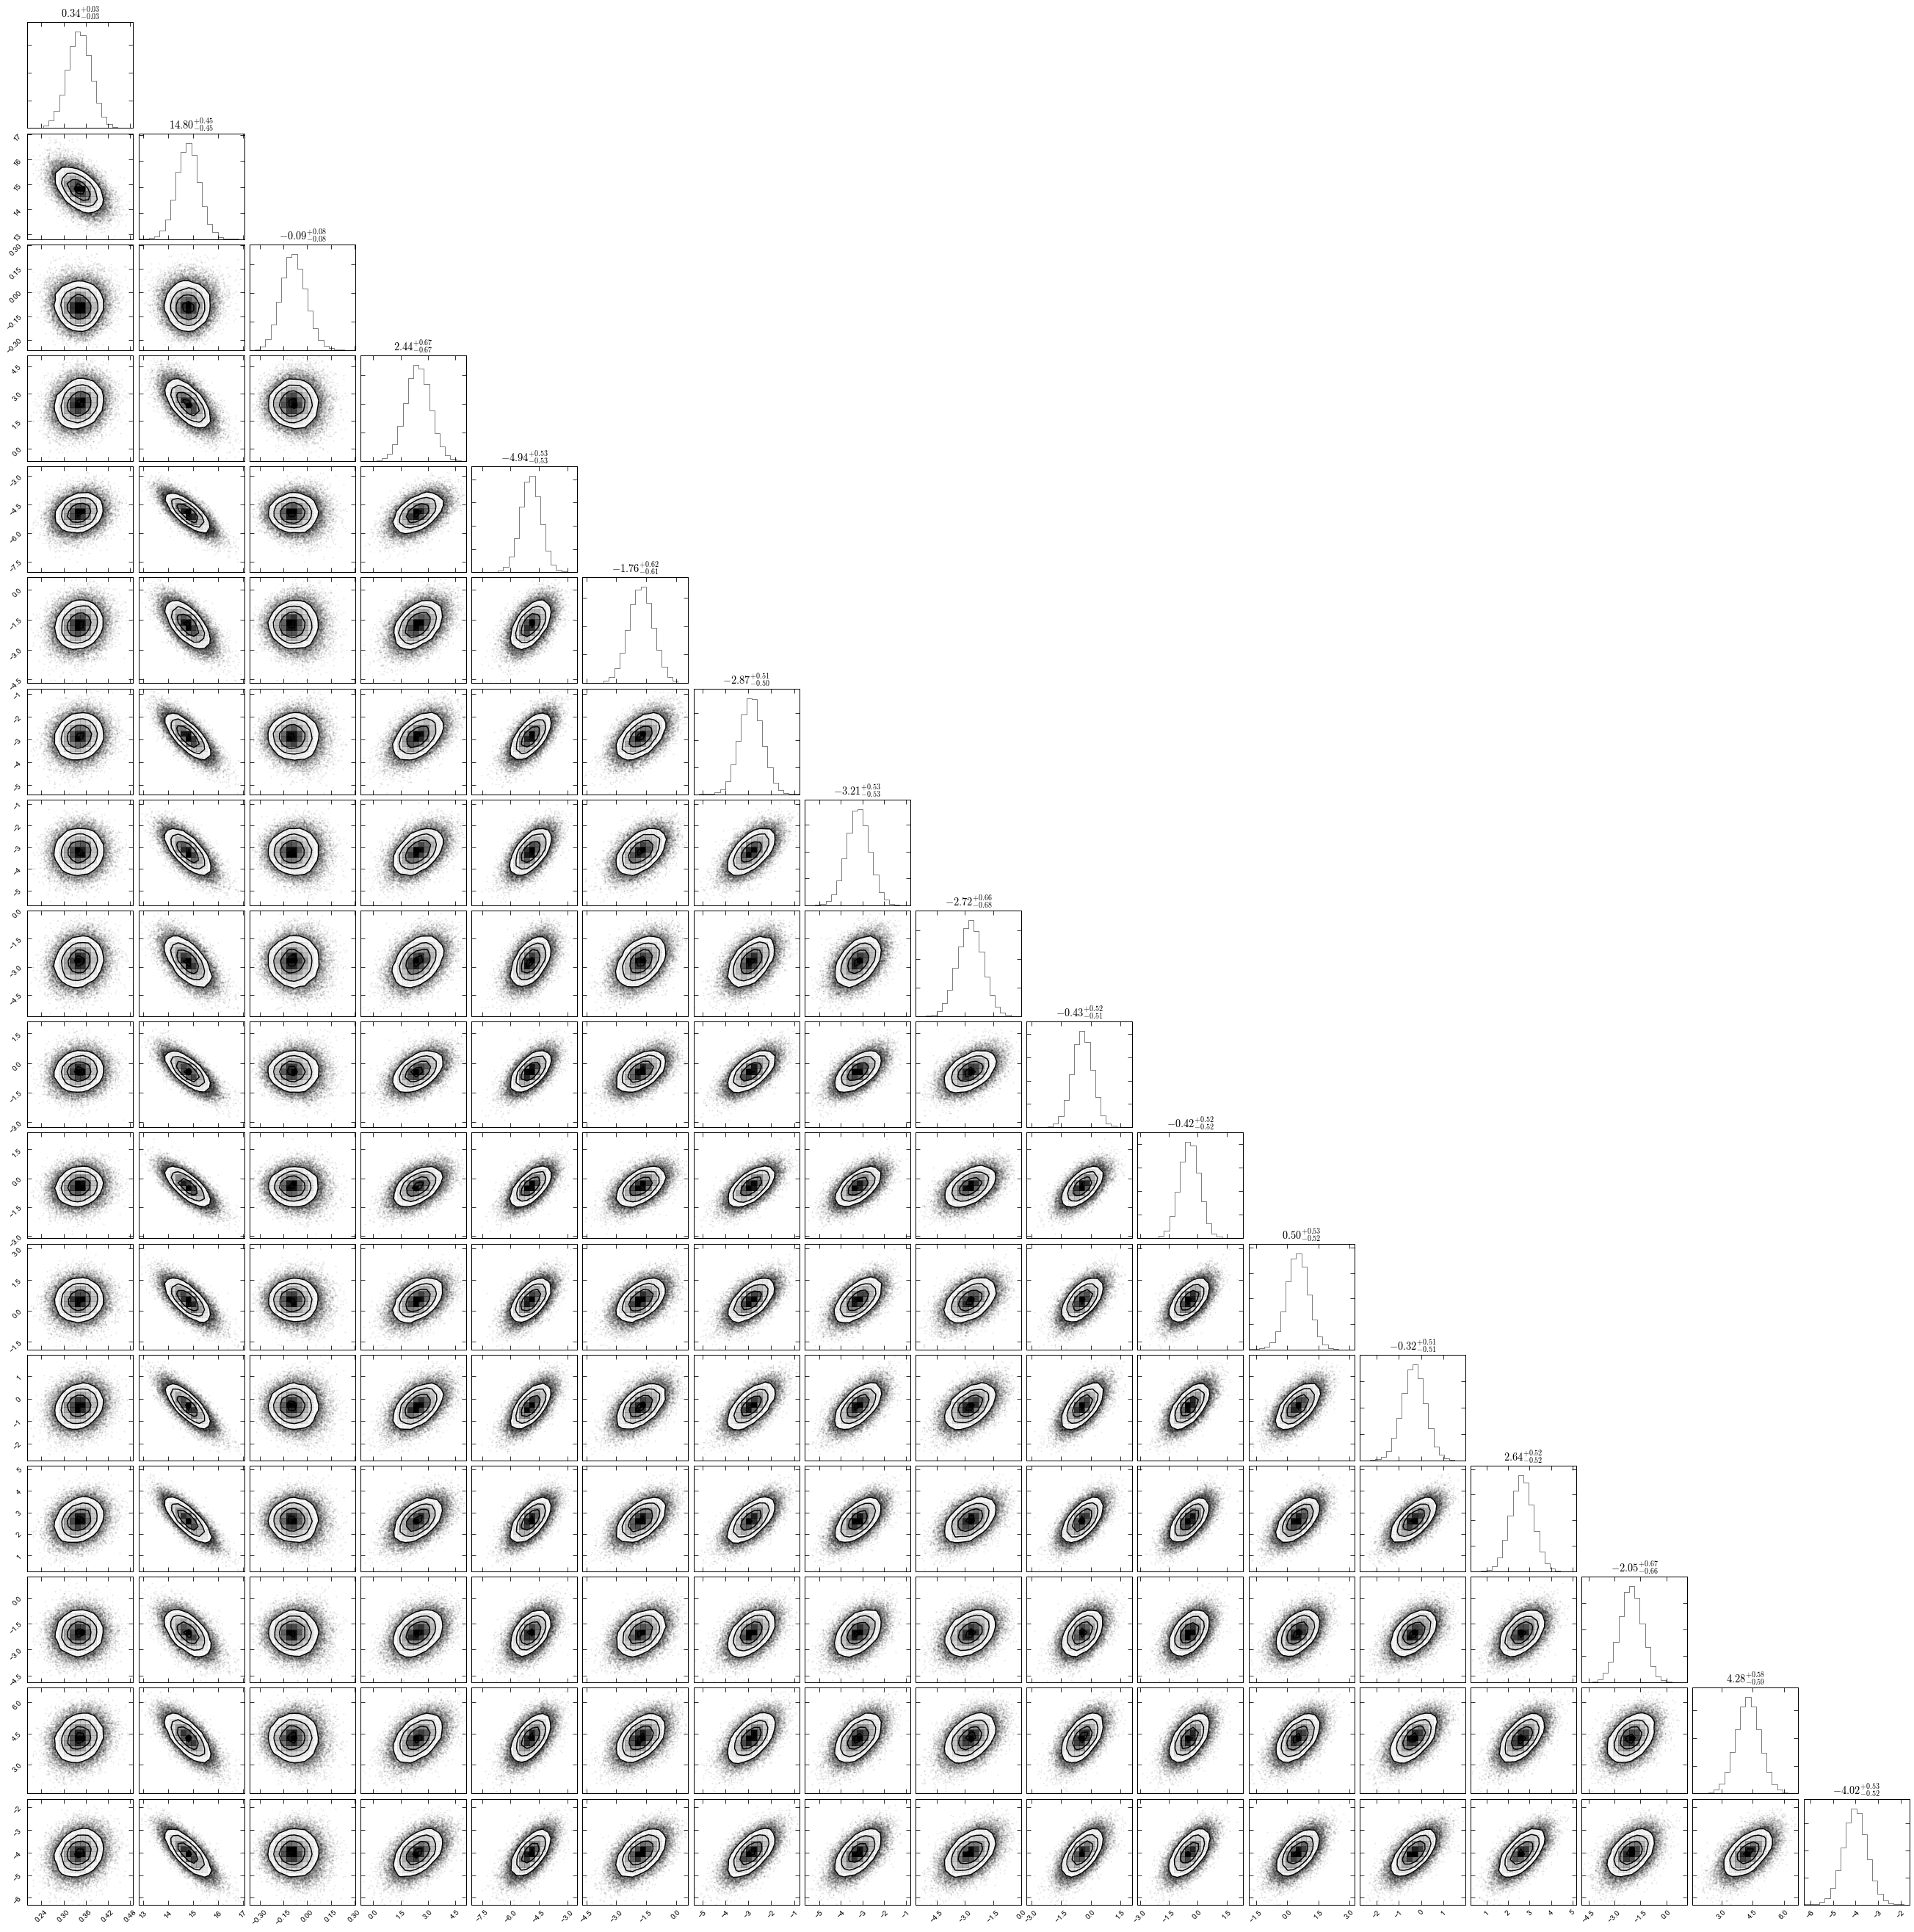

In [10]:
# show the constraints on all free parameters. These are the slope, intercept, scatter,
# and all the offsets of the individual classes with respect to class 0. 
fig = corner.corner(np.vstack((full_fit['m'],
                               full_fit['b'],
                               full_fit['lnf'],
                               full_fit['offsets'].T)).T,
                    show_titles=True)


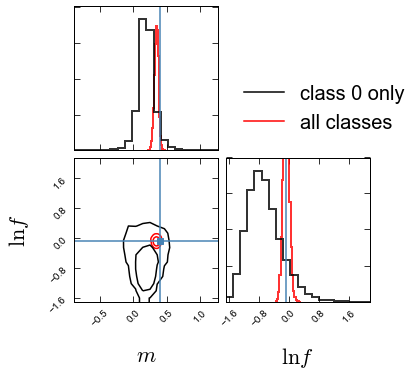

In [11]:
# now compare to the constraints we had before 
nbins=20
label_names = [r"$m $", r"$\ln f$"]

fig = corner.corner(np.vstack((full_fit['m'], full_fit['lnf'])).T,  labels = label_names, 
        label_kwargs = {'fontsize': 22}, levels=(0.68, 0.95,), plot_datapoints = False, 
        plot_density = False, color = 'r', bins = nbins, hist_kwargs = {'lw': 2, 'alpha' : 0.8})

fig = corner.corner(np.vstack((fit['m'], fit['lnf'])).T, fig = fig, labels = label_names, 
        label_kwargs = {'fontsize': 22}, levels=(0.68, 0.95,), plot_datapoints = False, 
        plot_density = False, color = 'k', bins = nbins, hist_kwargs = {'lw': 2, 'alpha' : 0.8}, 
        truths = [m_true, np.log(f_true)])

axnum = 1
fig.axes[axnum].plot([], [], 'k', label = 'class 0 only')
fig.axes[axnum].plot([], [], 'r', label = 'all classes ')
fig.axes[axnum].legend(loc = 'lower left', frameon = False, fontsize = 20)  